In [1]:
import numpy as np
import polytope as pc
from itertools import combinations

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from best.abstraction import LTIAbstraction
from best.mdp import MDP, ProductMDP, ParallelMDP
from best.ltl import solve_ltl_cosafe

from Models.Linear import LTI

# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2) #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[0,0],[0,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

In [2]:
# Define regions of interest for the labeling
target_regs = dict()
target_regs['target1'] = pc.box2poly(np.array([[-9, -6], [6, 9]]))
target_regs['target2'] = pc.box2poly(np.array([[6, 9], [6, 9]]))

In [3]:
## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
# d_opt, d_vals, eps_values = tune_dratio(sys_n)

d_opt = np.array([[ 0.69294],
                  [ 0.721  ]])

# d = np.array([[1.5], [1.5]])
d = d_opt

### Construct map MDP

In [4]:
p1 = 0.5
p2 = 0.6

T0 = np.eye(3)
T1 = np.array([[0,p1,1-p1], [0,1,0], [0,0,1]])
T2 = np.array([[0,p2,1-p2], [0,1,0], [0,0,1]])

def output_fcn(n):
    if n == 0:
        return 'init'    # label unknown
    if n == 1:
        return 'sample'  # there is a sample
    if n == 2:
        return 'empty'   # no sample
    
map1 = MDP([T0, T1], input_name='meas1',
                     output_fcn=output_fcn, output_name='samplelabel1')

map2 = MDP([T0, T2], input_name='meas2',
                     output_fcn=output_fcn, output_name='samplelabel2')

map_mdp = ParallelMDP([map1, map2])
print map_mdp

MDP: 4 inputs "(meas1, meas2)" --> 9 states "(samplelabel1, samplelabel2)"


### Construct abstraction

Warning no inputspace given
Warning no state space given
status: optimal
optimal epsilon 1.00000639831
optimal M [[ 1.  0.]
 [ 0.  1.]]
Optimal K [[ 0. -1.]
 [-1.  0.]]
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
MDP: 16 inputs "u_d" --> 871 states "(s, x_d)"


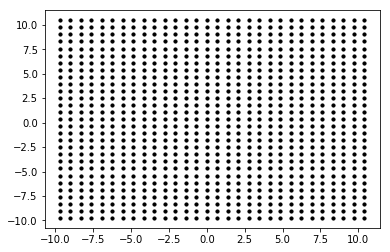

In [5]:
# mdp_grid = sys_n.abstract_io(d, un=4, verbose=False)  # do the gridding
# mdp_grid.map_dfa_inputs(dict_input2prop, regions)

abstr = LTIAbstraction(sys_lti, d, un=4)
abstr.set_regions(target_regs)

in_regions, nin_regions = abstr.map_dfa_inputs()

fig = plt.figure()
abstr.plot(fig)
print abstr.mdp

### Connect abstraction and map

In [6]:
# mapping (s, x_d) -> (meas1, meas2)
def map_connection(s_xd):
    if s_xd[0] == abstr.mdp.N-1:
        return set([(0,0)])
    
    x_d = np.array(s_xd[1]).reshape((2,1))
        
    ret = [0 for i in range(len(target_regs))]
    for i, poly in enumerate(target_regs.itervalues()):
        if poly.contains(x_d):
            ret[i] = 1
    return set([tuple(ret)])

prod_mdp = ProductMDP(abstr.mdp, map_mdp, map_connection)
print prod_mdp

MDP: 16 inputs "u_d" --> 7839 states "((s, x_d), (samplelabel1, samplelabel2))"


### Set up LTL problem

In [8]:
from best import subsets

formula = '( F sample )'

def get_regions(s):
    '''compute subsets of possible regions corresponding to abstract state'''   
    if s == abstr.mdp.N-1:
        return set([ (), ])
    
    know_in = []
    know_out = []
    for reg in target_regs.keys():
        if in_regions[reg][s] == 0:
            know_out.append(reg)
        if nin_regions[reg][s] == 0:
            know_in.append(reg)
    uncertain = list(set(target_regs.keys()) - set(know_in) - set(know_out))
    return set([ tuple(know_in + unc) for unc in subsets(uncertain)])  

# map ((s, xd), (sample1, sample2)) -> 2^{sample}
def abstract_connection(s_xd_sample):
    s = s_xd_sample[0][0]
    regs = get_regions(s)
    
    sample1 = s_xd_sample[1][0]
    sample2 = s_xd_sample[1][1]

    if all('target1' in reg for reg in regs) and sample1 == 'sample' or \
       all('target2' in reg for reg in regs) and sample2 == 'sample':
        return set([tuple(['sample'])])
    else:
        return set([(), ])

print abstract_connection( ( (728, (_, _)), ('sample', 'empty') ) )
print abstract_connection( ( (728, (_, _)), ('empty', 'empty') ) )

print abstract_connection( ( (749, (_, _)), ('empty', 'sample') ) )
print abstract_connection( ( (749, (_, _)), ('empty', 'empty') ) )

set([('sample',)])
set([()])
set([('sample',)])
set([()])


### Solve recursion

In [9]:
pol = solve_ltl_cosafe(prod_mdp, formula, abstract_connection, algorithm='sofie')

### Define policy

In [15]:
# define a policy on top of mdp policy
def my_policy(x, mapstate):
    # x: current concrete state [x; y]
    # sam1: current state of target1 {0,1,2}
    # sam2: current state of target2 {0,1,2}
    x = np.array(x).reshape((2,1))
    
    if any(poly.contains(x) and mapstate[i] == 1 for (i, poly) in enumerate(target_regs.itervalues())):
        aps = set(['sample'])
    else:
        aps = set([])
        
    pol.report_aps(aps)
    
    s_abstract = abstr.closest_abstract(x)
    
    s_tot = prod_mdp.global_state((s_abstract, mapstate ))
   
    u_abstract, curr_val = pol.get_input(s_tot)
    
    return abstr.refine_input(u_abstract, s_abstract, x)

def my_value(x):    
    x = np.array(x).reshape((2,1))
    
    s_abstract = abstr.closest_abstract(x)
    s_tot = prod_mdp.global_state( (s_abstract, (0,0)) )

    _, val = pol.get_input(s_tot)
    return val

def my_policy_init(x):
    u = my_policy(x, (0,0))
    pol.reset()
    return u


### Plot value function

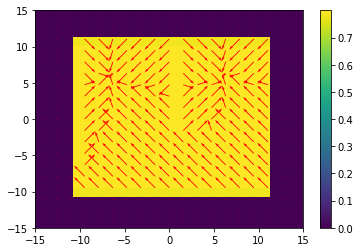

In [16]:
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

values = np.array([my_value((x,y)) for (x,y) in zip(xi, yi)])

plt.pcolor(x_edge, y_edge, values.reshape((49,49)))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

delx_fun = lambda x,y: sys_lti.a.dot(np.array([[x], [y]])) + sys_lti.b.dot(my_policy_init((x,y))) - np.array([[x], [y]])

delx = np.hstack([delx_fun(x,y) for (x,y) in zip(xi, yi)])

x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(xi, yi, delx[0], delx[1], color = 'r')


### Run a simulation

Matrix is singular and may not have a square root.
reached
reached
reached
reached
reached
reached


Text(0,0.5,u'x_2')

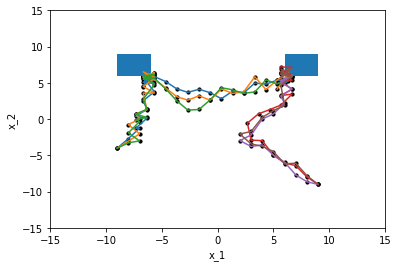

In [19]:
import scipy.linalg as scla
import matplotlib

np.random.seed(4)

time = 50
fig = plt.figure()
ax = fig.add_subplot(111)

realmap = [1, 2]    # sample at target1, not at target2

Wsqrt = scla.sqrtm(sys_lti.W)
for x0 in (np.array([[-9],[-4]]),np.array([[9],[-9]])):
    for repeating in range(3):
        pol.reset()
        mapstate = [0, 0]
        xx = x0
        
        for t in range(time): 
            # current state
            xt = xx[:,-1].reshape(2,1)
            # update map state
            for i, poly in enumerate(target_regs.itervalues()):
                if poly.contains(xt):
                    mapstate[i] = realmap[i]
            # next state
            ut = my_policy(xt, mapstate)
            wt = np.random.normal(0,1,size=(2,1))
            # update state
            xt1 = sys_lti.a.dot(xt)+sys_lti.b.dot(ut) + np.array(Wsqrt).dot(wt)

            xx = np.hstack([xx, xt1])

            if pol.finished() :
                print('reached')
                break
                
        if not pol.finished():
            print('not reached')
            
        plt.plot(xx[0,:],xx[1,:])
        plt.scatter(xx[0,:],xx[1,:], label='Finite states', color='k', s=10, marker="o")

# plot regions
for poly in target_regs.itervalues():
    V = pc.extreme(poly)
    ax.add_patch(matplotlib.patches.Polygon(V))
    
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

plt.xlabel('x_1') 
plt.ylabel('x_2') 
